# TD3: Spatial Discretization with Spectral Methods II

In this TD we continue to explore spectral methods to represent a given function and its derivatives. We will focus here on **Chebyshev representation** which most of the time can be seen as a reasonable alternative to Fourier representation in the case where the function that we want to approximate on a compact domain is regular but non-periodic.

We recall that spectral methods rely on the expansion of a function $f$ on a basis of functions $\{\phi_k\}_k$ (in a function space we do not specify at this point). The coefficients of the expansion will be noted $\hat{f}_k$. Thus we have:
$$
    f(x) = \sum_{k}\hat{f}_k\phi_k(x)
$$

The choice of the basis $\{\phi_k\}_k$ is obviously crucial for the efficiency of a numerical calculation. We will make sure for a practical case that the chosen basis meets the following requirements:
* **Convergence:** the series should converge rapidly enough to the function $f$
* **Transformation:** the computation of the coefficients $\hat{f}_k$ should be numerically fast, as well as the inverse transformation
* **Differentiation:** it should be easy to compute the derivative of $f$ through its expansion, meaning we can determine $\widehat{f^\prime}_k$ easily

As usual, we will need the following packages:

In [1]:
# To draw matplotlib plots within this notebook.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Part 1: Chebyshev interpolation

In spectral methods, given a set of points $\{x_k\}_k$ we define the interpolant $\mathbb{I}_N[f]$ of a function $f$ based on the series representation of $f$ on the basis $\{\phi_k\}_k$. Thus, we approximate $f$ by a truncated series:
$$
    \mathbb{I}_N[f] = \sum_{k = 0}^{N}\hat{f}_k\phi_k
$$
(depending on the chosen basis, we can have slightly different definitions of $\mathbb{I}_N[f]$). This function in an interpolation of $f$, and should therefore satisfy $\forall k, f(x_k) = \mathbb{I}_N[f](x_k)$.

### Chebyshev basis

Chebyshev interpolation relies on Chebyshev polynomials. Let us first see what the Chebyshev polynomials look like.

The Chebyshev polynomial of degree $n$ is the unique polynomial satisfying:
$$
    \forall \theta \in \mathbb{R}, T_n(\cos(\theta)) = \cos(n\theta)
$$
We can build Chebyshev polynomials with the following recursive definition:
$$
    \begin{cases}
        T_0(X) = 1\\
        T_1(X) = X\\
        T_{n+2}(X) = 2XT_{n+1}(X) - T_{n}(X) \text{ with } n \in \mathbb{N}
    \end{cases}
$$

**1)** Write a function which computes the $N + 1$ first Chebyshev polynomials for a given $N$, returning the coefficients of the polynomials in a matrix.

In [2]:
def shift(xs, n):
    e = np.zeros(len(xs) + n)
    e[n:] = xs
    return e

def chebyshev(N, memo = {}):
    if N in memo:
        return memo[N]
    out = np.zeros((N+1, N+1))
    if N == 0:
        tmp = np.zeros(len(out))
        tmp[0] = 1
        out[0, :] = tmp
        memo[0] = out
        return out
    if N == 1:
        tmp = np.zeros(len(out))
        tmp[1] = 1
        out[1, :] = tmp
        tmp[1] = 0
        tmp[0] = 1
        out[0, :] = tmp
        memo[1] = out
        return out
    Tn1 = chebyshev(N-1)
    Tn = chebyshev(N-2)
    new = 2*shift(Tn1[N-1, :], 1) 
    new[:N-1] -= Tn[N-2, :]
    out[:N, :N] = Tn1
    out[N, :] = new
    memo[N] = out
    return out


In [3]:
chebyshev(4)

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [-1.,  0.,  2.,  0.,  0.],
       [ 0., -3.,  0.,  4.,  0.],
       [ 1.,  0., -8.,  0.,  8.]])

**2)** Write a function which computes from an arbitrary set of points and for a given set of coefficients $\{a_k\}$ the values of the polynomial $\sum_k{a_k}X^k$ evaluated at the input points.

In [4]:
def evaluate(coef, points):
    out = [coef[i] * points**i for i in range(len(coef))]
    return np.sum(out, axis = 0)


**3)** Using the previous functions, plot the first Chebyshev polynomials.

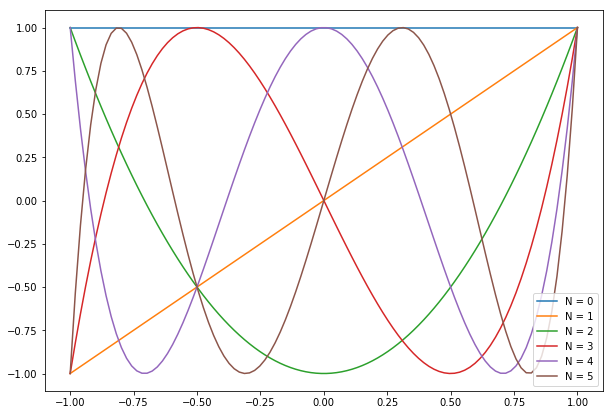

In [5]:
N = 6
xtab = np.linspace(-1, 1, 100)
cheb_coef = chebyshev(N)


plt.figure(figsize=(10, 7))

for i in range(N):
    plt.plot(xtab, evaluate(cheb_coef[i, :], xtab), label = "N = {}".format(i))

plt.legend()
plt.show()



Now that we have a more concrete view on Chebyshev polynomials, we can use them to approximate a function $f$. We will now restrict to a function $f$ which is defined on the spatial domain $[-1,1]$, but as before, this is easily generalizable to a function defined on any compact domain $[a,b]$ through a scaling.

For a given $N$, we define a grid of the spatial domain as follows:
$$
    x_j = \cos(\theta_j) \text{ with } \theta_j = \frac{\pi j}{N} \text{ and } j=0,...,N
$$
We can note we have one more point on the grid in comparison with Fourier basis for the same value of N.
We also define the interpolant of $f$ as follows:
$$
    \mathbb{I}_N[f](x) = \sum_{n=0}^N\hat{f}_nT_n(x)
$$

The determination of the interpolant for a given function on the previsouly defined grid also relies on the FFT. More precisely, it can be computed using the [Discrete Cosine Transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform). To save some time, we can use the following function which computes the coefficients of the interpolant from a given set of values $\{f(x_j)\}_j$:

In [6]:
import scipy as scp
import scipy.fftpack

def cheb_transform(x):
    ret = scp.fftpack.dct(x, type=1) / (2*(len(x) - 1))
    ret[1:-1] = ret[1:-1] * 2
    return ret

This function has a $\mathcal{O}(N\log(N))$ complexity.

**4)** Write a function which computes from an arbitrary set of points and for a given set of coefficients $\{\hat{f}_n\}_n$ the values of $\mathbb{I}_N[f]$ evaluated at the input points. We will not care about the complexity of the algorithm.

In [7]:
def interpolate(points, coef):
    N = len(coef)-1
    cheb_coef = chebyshev(N)
    out = 0
    for i in range(N + 1):
        out += coef[i]*evaluate(cheb_coef[i, :], points)
    return out


**5)** Compare by plotting on $[-1,1]$ in the following cases the exact function with its interpolant for several values of $N$:
* $f(x) = \cos((x + 1)\pi) + \sin(2(x + 1)\pi)$
* $  f(x) = \begin{cases}
    \frac{\pi}{4} & \text{if } -1 \leq x < 0 \\
    -\frac{\pi}{4} & \text{if } 0 \leq x < 1
  \end{cases}$
* $ f(x) = 1/(1+25x^2)$

In which cases Chebyshev interpolants seem to be relevant approximations? Can you see a Gibbs phenomenon for one of these interpolants?

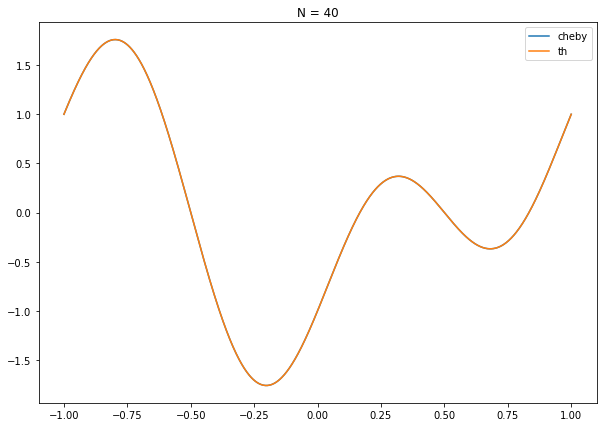

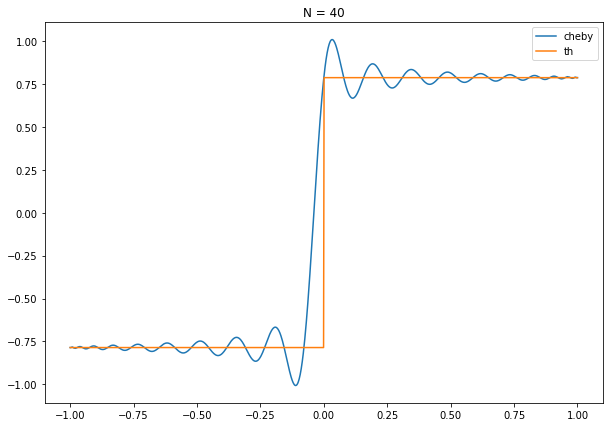

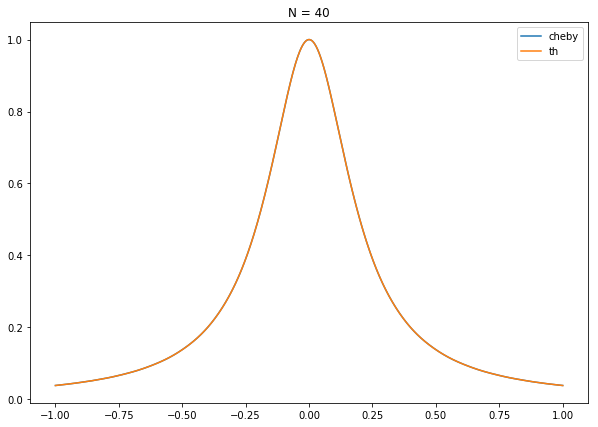

In [8]:
def create_interpolation(f, xm):
    coef = cheb_transform(f(xm))
    return coef

def compare(f, N, xtab):
    xm = np.cos(np.pi*np.arange(0, N+1)/N)
    coef = create_interpolation(f, xm)
    plt.figure(figsize = (10, 7))
    plt.title('N = {}'.format(len(coef) - 1))
    plt.plot(xtab, interpolate(xtab, coef), label = 'cheby')
    plt.plot(xtab, f(xtab), label = 'th')
    plt.legend()
    plt.show()

N = 40
xm = np.cos(np.pi*np.arange(0, N+1)/N)
xtab = np.linspace(-1, 1, 1000)
compare(lambda x : np.cos((x+1)*np.pi) + np.sin(2*(x+1)*np.pi), N, xtab)
compare(lambda x : np.pi/4 * np.sign(x), N, xtab)
compare(lambda x : 1/(1 + 25*x**2), N, xtab)

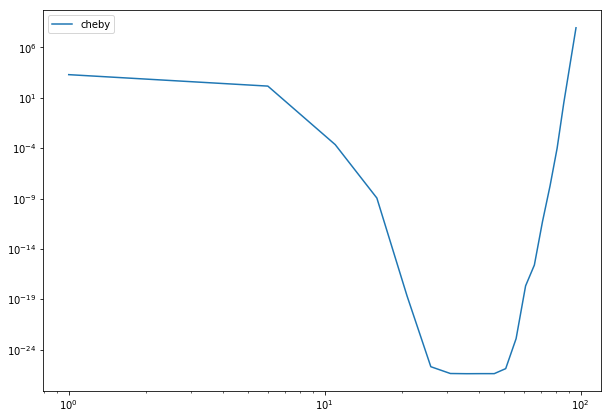

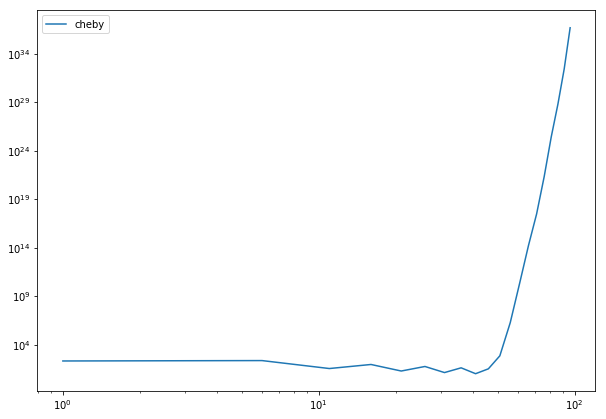

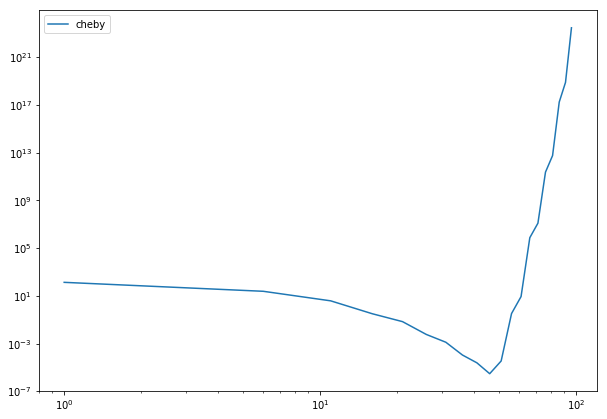

In [9]:
def error_evol(f, xtab, Ntab):
    error = np.zeros(len(Ntab))
    for (i, N) in enumerate(Ntab):
        xm = np.cos(np.pi*np.arange(0, N+1)/N)
        coef = create_interpolation(f, xm)
        yInterpol = interpolate(xtab, coef)
        yReal = f(xtab)
        error[i] = np.dot(yInterpol - yReal, yInterpol - yReal)
    
    plt.figure(figsize = (10, 7))
    plt.loglog(Ntab, error, label = 'cheby')
    plt.legend()
    plt.show()

N = 40

xtab = np.linspace(-1, 1, 1000)
Ntab = np.arange(1, 100, 5)
error_evol(lambda x : np.cos((x+1)*np.pi) + np.sin(2*(x+1)*np.pi), xtab, Ntab)
error_evol(lambda x : np.pi/4 * np.sign(x), xtab, Ntab)
error_evol(lambda x : 1/(1 + 25*x**2), xtab, Ntab)

## Part 2: Spectral differentiation with Chebyshev representation

Spectral representations will be useful to solve a differential equation only if we can easily differentiate them. In this part, we will see how we can do that within a Chebyshev representation of a given function $f$.

### Chebyshev representation

Using the same notations as before, we already defined an interpolant $\mathbb{I}_N[f]$ which approximates $f$. It is easy to differentiate $\mathbb{I}_N[f]$:
$$
    \mathbb{I}_N[f]^\prime(x) = \sum_{n=0}^N\hat{f}_nT_n^\prime(x)
$$

Now we can wonder if this function is still a good approximation of $f^\prime$.

**1)** Show using $\theta$ variable that:
$$
    \mathbb{I}_N[f]^\prime(\cos(\theta)) = \frac1{\sqrt{1-\cos(\theta)^2}}\sum_{n=0}^Nn~\hat{f}_n\sin(n\theta) \text{ with } \theta \in ]0,\pi[
$$
Then show that:
$$
    \mathbb{I}_N[f]^\prime(1) = \sum_{n=0}^Nn^2~\hat{f}_n\\
    \mathbb{I}_N[f]^\prime(-1) = \sum_{n=0}^N(-1)^{n+1}n^2~\hat{f}_n
$$

**2)** Write a function which computes the values $\{\mathbb{I}_N[f]^\prime(x_j)\}_j$ given the coefficients of $\mathbb{I}_N[f]$. Complexity should be a $\mathcal{O}(N\log(N))$.

To save some time, we can use the following function which relies on the [Discrete Sine Transform](https://en.wikipedia.org/wiki/Discrete_sine_transform) and its FFT algorithm ($\mathcal{O}(N\log(N))$ complexity) and computes $M$ values $\{v(\theta_j)\}_j$ for a given set of $M$ coefficients $\{\hat{v}_m\}_m$, related to each other through the following formula:
$$
    v(\theta_j) = \sum_{m=1}^M\hat{v}_m\sin(m\theta_j) \text{ with } \theta_j = \frac{\pi (j + 1)}{M + 1} \text{ and } j = 0,...,M - 1
$$

In [62]:
def inv_dst(x):
    return scp.fftpack.idst(x / 2, type=1)

In [63]:
def interpolate_der(xtab, coef):
    der_coef = np.polynomial.chebyshev.chebder(coef)
    poly = np.polynomial.chebyshev.Chebyshev(der_coef)
    return poly(xtab)


**3)** Compare by plotting the exact value of $f^\prime$ and the approximation $\mathbb{I}_N[f]^\prime$ in the following cases:
* $f(x) = \cos((x + 1)\pi) + \sin(2(x + 1)\pi)$
* $  f(x) = \begin{cases}
    \frac{\pi}{4} & \text{if } -1 \leq x < 0 \\
    -\frac{\pi}{4} & \text{if } 0 \leq x < 1
  \end{cases}$
* $ f(x) = 1/(1+25x^2)$

Discuss what you observe.

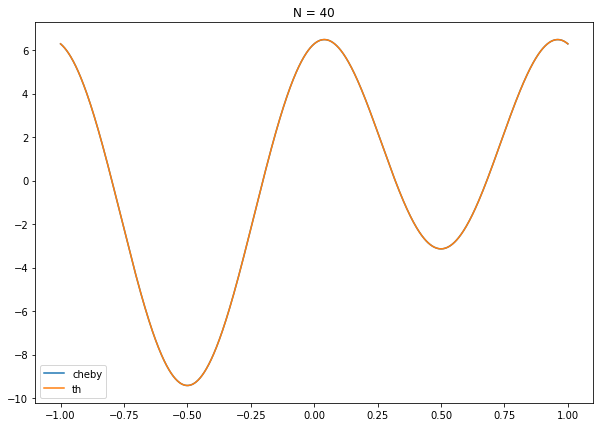

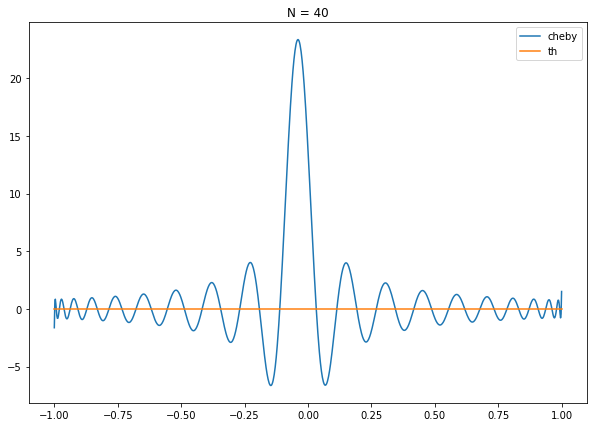

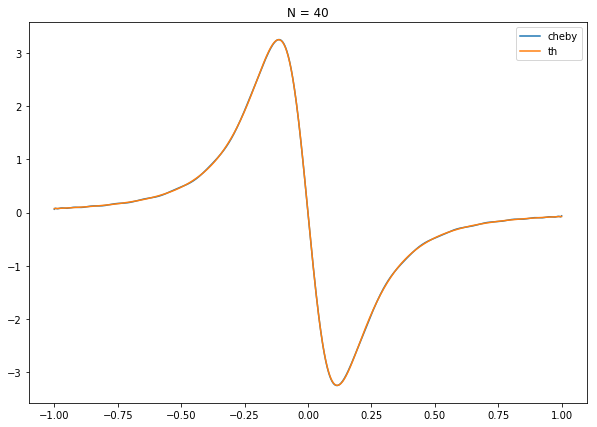

In [64]:
def compare_der(f, df, N, xtab):
    xm = np.cos(np.pi*np.arange(0, N+1)/N)
    coef = create_interpolation(f, xm)
    plt.figure(figsize = (10, 7))
    plt.title('N = {}'.format(len(coef) - 1))
    plt.plot(xtab, interpolate_der(xtab, coef), label = 'cheby')
    plt.plot(xtab, df(xtab), label = 'th')
    plt.legend()
    plt.show()
    
    
N = 40
xm = np.cos(np.pi*np.arange(0, N+1)/N)
xtab = np.linspace(-1, 1, 1000)
compare_der(lambda x : np.cos((x+1)*np.pi) + np.sin(2*(x+1)*np.pi), 
            lambda x : -np.sin((x+1)*np.pi)*np.pi + np.cos(2*(x+1)*np.pi)*2*np.pi,
            N, xtab)
compare_der(lambda x : np.pi/4 * np.sign(x), 
            lambda x : 0*x,
            N, xtab)
compare_der(lambda x : 1/(1 + 25*x**2), 
            lambda x : -50*x/((1 + 25 * x**2)**2),
            N, xtab)



## [BONUS] Part 3: Lagrange interpolation and the Runge phenomenon

Chebyshev interpolation can be seen as a polynomial interpolation of a function based on grid points that are not evenly spaced. Indeed these grid points are cosine projections of evenly spaced points. One can wonder why we could not use an evenly spaced grid to define a polynomial interpolation. Let us see what can happen.

We want to approximate the function $f(x) = 1 / (1 + 25x^2)$ on $[-1,1]$ using a polynomial interpolation on a regular grid.

For a given $N$ we define a grid of $N + 1$ points $\{x_j\}_{0\leq j \leq N}$ on $[-1, 1]$ by:
$$
    x_j = -1 + \frac{2j}{N} \text{ with } j=0,...,N
$$

A polynomial interpolation on this grid can be defined using Lagrange polynomials. We recall that the Lagrange polynomials $\{\mathcal{l}_k\}_k$ associated to a given grid of $N + 1$ points $\{x_j\}_{0\leq j \leq N}$ are defined as:
$$
    \mathcal{l}_k (x) = \prod_{0 \leq j \leq N, j\neq k}\frac{x - x_j}{x_k-x_j}
$$
Thus, they verify the relation: $\mathcal{l}_k (x_j) = \delta_{j,k}$

The polynomial interpolant of a function $f$ on the grid $\{x_j\}_{0\leq j \leq N}$ is then simply:
$$
    \mathbb{I}_N[f](x) = \sum_{k=0}^N\hat{f}_k\mathcal{l}_k(x) \text{ with } \hat{f}_k = f(x_k)
$$

**BONUS: 1)** $\mathbb{I}_N[f]$ can be written $\mathbb{I}_N[f](X) = \sum_{k=0}^Na_kX^k$. Using [scipy.interpolate.lagrange](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html) define a function that computes the $\{a_k\}_{0\leq k \leq N}$ coefficients associated to the function $f(x) = 1 / (1 + 25x^2)$ for a given value of $N$.

**BONUS: 2)** Plot on $[-1,1]$ for several values of $N$ the function $f$ and its interpolant $\mathbb{I}_N[f]$. What happens when you increase the order of interpolation $N$? Conclude on the interest of evenly spaced grids for polynomial interpolation.